Assignment Brief: 

You are an equity analyst working for an active fund manager. One of the fund’s investment managers has approached you after listening to an interesting podcast. The podcast discussed an experiment in which shares were automatically bought or sold based on the sentiment of Donald Trump’s tweets.

Thus, the investment manager would like to explore some ideas with you about using tweets to predict share price movements and boost the fund’s investment performance.

After discussing this idea with the investment manager, you agree to investigate the relationship between tweets and the Australian Stock Exchange (ASX) share price movements in the television industry. You have decided to focus on the television industry because you expect that there is a strong relationship between television networks and celebrities who frequently post to Twitter.


Tasks(in my own words): 
- Vectorise text using NLP techniques 
- Perform unsupervised learning on tweets text 
 - Principal Component Analysis (PCA) and k-means
- Create neural network to predict if share prices go up
- Perform Tree based modelling

Sections in this notebook (As of 30/8/2021)
- Environment
 - Packages 
 - Functions
- Data
 - Import Data
 - Exploratory Data Analysis
- Modelling
 - Clean
 - TFIDF Vectorisation
 - PCA
 - k-means
- Share price models


# Environment

## Packages

In [ ]:
# Packages for data management.
import pandas as pd
import numpy as np

# Packages to be used in pre-processing the text.
import re
import nltk
nltk.download('stopwords')  # For a standard list of stopwords.
nltk.download('wordnet')    # For lemmatisation.
import pkg_resources
!pip install symspellpy
from symspellpy import SymSpell, Verbosity

# Libraries from Scikit-learn are used to standardise the
# features and perform PCA.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Libraries from nltk used for tokenising text
from nltk.tokenize import word_tokenize
  # 'word_tokenize' is a tokeniser for natural language.
  # There are many such options available.
import nltk
nltk.download('punkt')

# Packages for visualisation.
!pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Libraries from Sci-kit learn used for vectorisation using TF-IDF and t-SNE.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

## For clustering sentences using K-Means clustering.
from sklearn.cluster import KMeans
## For evaluating the clustering model.
from sklearn.metrics import silhouette_score

# Packages for datetime manipulation 
import datetime
from datetime import datetime

# Packages used for pseudo-random number generation
import random 

# Package used to manipulate emojis
!pip install emot
import re
import pickle
from emot.emo_unicode import UNICODE_EMOJI,EMOJI_UNICODE, EMOTICONS_EMO, UNICODE_EMOJI_ALIAS

# Set options 
pd.set_option('display.float_format', lambda x: '%d' % x)
pd.options.display.max_colwidth
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 2.6 MB 5.1 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 61 kB 18 kB/s 


## Functions

### Production

In [ ]:
# Function to sample texts at different lengths
def sample_percent(percentile,sample_size):
    length_at_percentile = np.quantile(df['tweet_text'].str.len(), percentile)
    df_subset = df.loc[(df['tweet_text'].str.len() > length_at_percentile)]
    df_sample = df_subset.sample(n = sample_size, random_state = np.random.randint(10))
    df_tweets = df_sample['tweet_text']
    for tweet in df_tweets:
      print('text: '+tweet)

In [ ]:
# Functions for emoji manipulation
## Function to convert emojis to words
def convert_emoji(text):
    text = text
    for emot in UNICODE_EMOJI_ALIAS:                  # Dictonary of emojis defined in emoji package
        text = text.replace(emot, "_".join(UNICODE_EMOJI_ALIAS[emot].replace(",","").replace(":","").split()))
    return text

## Function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"   # emoticons
                           u"\U0001F300-\U0001F5FF"   # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"   # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"   # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    emoji_pattern = emoji_pattern.sub(r'', text)
    emoji_pattern = emoji_pattern.lower()
    return emoji_pattern

In [ ]:
# Function to clean tweets
def clean_text(text, rmlinks, rmHT, rmRT, emoji_ind, spell_ind, stem_ind, lemm_ind):
    # Create variable
    result = text
    # Remove links
    if (rmlinks == 1):
      result = re.sub(r"http\S+", "", result)
    else :
      result = result

    # Remove hashtags
    if rmHT == 1:
      result = re.sub(r"#\S+", "", result)
    else:
      result = result
 
    # Remove RT @
    if rmRT == 1:
      result = re.sub(r"RT @\S+", "", result)
    else:
      result = result
      
    # Emoji treatment
    if emoji_ind == 1:
      result = remove_emoji(result)
    else: 
      result = result
    if emoji_ind == 2:
      result = convert_emoji(result)
    else: 
      result = result

    # Remove alphanumeric
    # This step is always performed
    result = re.sub(r'[^\w\s]', '', str(result).strip())
    
    # Lower case
    # This step is always performed
    result = result.lower()
    
## Tokenise
    text_list = result.split()
    
    # Spelling
    if spell_ind == 1:
      text_list_spell = []
      for word in text_list:
          suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
          if suggestions:
             text_list_spell.append(suggestions[0].term)
          else:
             pass
      text_list = text_list_spell[:]
    else: 
      text_list = text_list
    
    # Remove stop words
    text_list = [word for word in text_list if word not in stopwords]
  
    # Perform stemming
    if stem_ind == 1:
      ps = nltk.stem.porter.PorterStemmer()
      text_list = [ps.stem(word) for word in text_list]
    else:
      text_list = text_list
      
    # Perform lemmatisation
    if lemm_ind == 1:    
      wnl = nltk.stem.wordnet.WordNetLemmatizer()
      text_list = [wnl.lemmatize(word) for word in text_list]
    else:
      text_list = text_list
    result = ' '.join(text_list)
    return text_list

In [ ]:
# Function to convert list to string  
def listToString(s): 
    # initialize an empty string
    str1 = " "     
    # return string  
    return (str1.join(s))

In [ ]:
## Function to create dictionary of words(now superfluous due to get_feature_names() function in tdf vectoriser)
def create_dictionary(tweet_vector):   
  a = []
  for word in tweet_vector:
    if word not in a:
      a.append(word) 
  return a

In [ ]:
# Function to obtain the explained variances from the PCA features.
def plot_explained_variances(pca):

    exp_var_pca = pca.explained_variance_ratio_

    # Calculate the cumulative sum of variances explained.
    # This will be used to create a scree plot for visualising the variance
    # explained by each principal component.

    cum_sum_var = np.cumsum(exp_var_pca)
    
    # Create the plot
    plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center',
            label='Individual explained variance',color='dodgerblue')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [ ]:
# Function to create a word cloud from the words in the dataset.
def get_wordcloud(topic,model,blacklist=[]):

    print('Getting wordcloud for topic {} ...'.format(topic+1))
    body_list = list(test['tweet_text'][test[model] == topic])
    
    for each in blacklist:
        body_list = [w.replace(each, '') for w in body_list]
    tokens = ' '.join(body_list)
    wordcloud = WordCloud(width=800, height=560,
                          background_color='white', collocations=False,
                          min_font_size=10).generate(tokens)

    # plot the WordCloud image
    plt.figure(figsize=(8, 5.6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=5)

In [ ]:
## Define a function to plot elbow curve - to select k-means clusters
def plot_elbow(K,WCSS):
    plt.figure(figsize=(16,8))
    plt.plot(K, WCSS,color='dodgerblue')
    plt.xlabel('k')
    plt.ylabel('WCSS')
    plt.title('Elbow curve for tweets')
    plt.show()

# Data

### Import Data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# Load tweets
infolder = '/content/gdrive/My Drive/Datasets/'
file_name_tweets = 'DAA 2021 S2 Assignment - data tweets.csv'
df = pd.read_csv(infolder+file_name_tweets, encoding = 'ISO-8859-1')
df['tweet_text'] = df.apply(lambda row: bytes(row['tweet_text'],'iso-8859-1').decode('utf-8',errors='ignore'), axis = 1)

In [ ]:
# Load share prices
# Load Channel 9 - from domain research, Sevenwest has more diversified holdings
# and less likely to find relationship with tweets 
infolder = '/content/gdrive/My Drive/Datasets/'
file_name_prices = 'DAA 2021 S2 Assignment - data NEC prices.csv'
df_shares = pd.read_csv(infolder+file_name_prices)

In [ ]:
# Get spelling datasets.
sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename('symspellpy', 'frequency_dictionary_en_82_765.txt')
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Add some common words to the dictionary that are likely to be found in the
# case study corpus, to avoid them being incorrectly 'fixed' by the spell checker.
sym_spell.create_dictionary_entry('covid', 5)
sym_spell.create_dictionary_entry('coronavirus', 5)

True

### Exploratory Data Analysis


#### 1.1 Shape of Data

In [ ]:
# Shape of data
print(df.shape)

(147421, 15)


#### 1.2 Column names and types

In [ ]:
# Find column names and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147421 entries, 0 to 147420
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         147421 non-null  int64  
 1   username           147421 non-null  object 
 2   name               147421 non-null  object 
 3   tweet_id           147421 non-null  float64
 4   tweet_post_time    147421 non-null  object 
 5   tweet_text         147421 non-null  object 
 6   tweet_likes        147421 non-null  int64  
 7   tweet_retweets     147421 non-null  int64  
 8   user_followers     147421 non-null  int64  
 9   user_friends       147421 non-null  int64  
 10  user_likes         147421 non-null  int64  
 11  user_tweets        147421 non-null  int64  
 12  user_public_lists  147421 non-null  int64  
 13  user_start_date    147421 non-null  object 
 14  retweet            147421 non-null  object 
dtypes: float64(1), int64(8), object(6)
memory usage: 16

#### 1.3 View random selection of tweets

In [ ]:
# View random 5 tweets 
df_sample = df.sample(n = 5, random_state= np.random.randint(58))
df_sample

,Unnamed: 0,username,name,tweet_id,tweet_post_time,tweet_text,tweet_likes,tweet_retweets,user_followers,user_friends,user_likes,user_tweets,user_public_lists,user_start_date,retweet
135086,1800,@SCrawf9,Shane Crawford,316000000000000000,25/03/2013 2:02,Last chance to WIN for kids n oldies at http://t.co/iMH2EBApfj http://t.co/RuBLNeucZt,0,0,100913,677,158,2198,172,15/09/2011 8:17,FALSE
29132,2845,@GotTalentAU,Australia's Got Talent,369000000000000000,18/08/2013 9:21,RT @Erica_Monique_S: @GotTalentAU May the paws be with you!,0,1,21074,232,1105,5601,58,9/05/2011 8:17,Erica_Monique_S
96894,503,@matty_russell,Matthew Russell,1160000000000000000,3/08/2019 8:28,🙌🏻 @cgoodlet https://t.co/motgTlMk3y,3,0,847,1444,5507,6921,9,2/04/2009 4:27,FALSE
244,244,@Channel7,Channel 7,1400000000000000000,26/05/2021 5:44,RT @BigBrotherAU: Big Brother has snuck some poultry into the #BBAU House! Feathers will fly tonight 7.30 on @channel7. https://t.co/ZkZJCo…,0,8,212355,2177,22933,28871,613,16/01/2013 0:23,BigBrotherAU
135313,2027,@SCrawf9,Shane Crawford,231000000000000000,3/08/2012 5:17,Do cows have calf muscles?,7,18,100913,677,158,2198,172,15/09/2011 8:17,FALSE


In [ ]:
# Print sample of longest and shortest tweets
# Random sample at 99th percentile length
sample_percent(0.99,3)
# Random sample at 1st percentile length
sample_percent(0.01,3)

text: Professor Giacomo Grasselli is an intensive care specialist at ground zero of Italy’s exponential outbreak. Four weeks ago, the state of Lombardy had 750 ICU beds, now they have upwards of 3,000 coronavirus patients needing those beds. It’s a medical warzone. #60Mins https://t.co/cM5aseeQQx
text: Hopeful homebuyers frozen out of the property market will be among the winners on budget night with the government announcing help is coming. Among the promises are lower deposits for single-parent households but Labor says the devil is in the detail. https://t.co/FtCHicwDBX https://t.co/UDfhAftWWg
text: .@HeatBBL: Green, Redmayne (wk), Jonassen (c), Harris, L Kimmince, Kerr, de Klerk, Voll, D Kimmince, Prestwidge, Hancock

@StrikersWBBL: McGrath, Mack, Wolvaardt, Patterson, Taylor, Wellington, Penna, McPharlin (wk), Coyte, Schutt (c), Brown

Tune in from 12pm on 7mate! #WBBL06 https://t.co/g5D2mJNbp0
text: Shocked and saddened by Drew Morphett's passing. Genuinely loved by all in sport 

#### 1.4 Check distinctness of tweets

In [ ]:
# Check that tweets are distinct

# Create a combination of tweet time and tweet_text
df['time_text_id'] = df['tweet_post_time'].add(', ' + df['tweet_text'])

# Count of tweet_time combinations
df['time_text_id'].value_counts()
# Print example of duplicate. 

11/04/2017 21:54, @BenFordham what a man. Ate a scorpion 🦂 😂 @TheTodayShow                                                                                                                                          4
29/07/2019 8:30, RT @Channel9: The greatest moments of the year have been on @Channel9, and the best is still to come... It all starts with #TheBlock Sunday…                                                       4
23/06/2019 10:51, RT @Channel9: Brace yourself, the greatest television is still to come on @channel9! https://t.co/ESgqkPCvjg                                                                                      3
5/06/2019 10:04, RT @Channel9: The greatest television is still to come! https://t.co/g2Cb0JfHom                                                                                                                    3
16/05/2021 1:05, RT @7NewsSydney: COVID-19 restrictions that were mandated by Premier @GladysB two weeks ago will be removed at 12:01am tonight 

#### 1.5 Check distinct users

In [ ]:
# Distinct usernames
print(df['name'].unique())

['Channel 7' '7NEWS Australia' 'Peter Mitchell' 'David Brown' 'Sunrise'
 'Samantha Armytage' 'David Koch' 'Home and Away' 'Ada Nicodemou'
 "Australia's Got Talent" 'Shane Jacobson' 'Big Brother Australia'
 'Sonia Kruger' '#DancingAU' 'Daryl Somers' 'SAS Australia on 7'
 'Farmer Wants A Wife' 'The Chase Australia' 'BetterHomes&Gardens'
 'The Front Bar' 'Mick Molloy' '7AFL' 'Brian Taylor' '7Cricket'
 '7HorseRacing ð\x9f\x90\x8e' 'Emma Vosti' 'Giaan Rooney'
 'Johanna Griggs AM' 'The Voice Australia' 'Emma Hamilton' 'Channel9'
 '9News Australia' '60 Minutes Australia' 'Liz Hayes' 'A Current Affair'
 'tracy grimshaw' 'The Today Show' 'Matthew Russell' 'Karl Stefanovic'
 'Allison Langdon' 'Amazing Grace' 'Doctor Doctor' 'Rodger Corser'
 'Nicole da Silva' '#9Survivor' 'Australian Ninja Warrior'
 'Rebecca Maddern' 'The Block' 'Hamish Blake' 'LEGO Masters Australia'
 'Married At First Sight' 'Millionaire Hot Seat' 'Eddie McGuire'
 'Weakest Link Australia' 'NRL on Nine' 'Postcards'
 'Carols by C

In [ ]:
# Print sample of longest and shortest tweets
# Random sample at 99th percentile length
sample_percent(0.99,3)
# Random sample at 1st percentile length
sample_percent(0.0001,3)

text: .@SallyBowrey7 met some talented home-grown designers at the centre of the First Nations Fashion + Design show at @AUSFW. The Fashion Week first has been hailed as the highlight of the week as First Nations designers, models and organisers put on a breathtaking show. https://t.co/jo9Sa1BmsN
text: Today marked a special milestone for our Olympic athletes, the unveiling of their uniforms for the Opening Ceremony in Tokyo in July. Featuring our national colours, the outfits remember our past champions while giving a nod to the Japanese hosts. https://t.co/Rql2Eda0bd #7NEWS https://t.co/pfPx25PZhZ
text: It is no secret that kids need sleep and exercise to stay fit and healthy, but exactly how much should they be getting? Adelaide researchers are turning the advice on its head, revealing there is some wriggle room. 7NEWS at 6pm | https://t.co/zAaFSMUzU5 @CaseyTreloar7 #7NEWS https://t.co/VLyv4AYy9g
text: RT @sunriseon7: .@Sam_Armytage spoke to Tahtra resident Helen Bruce who stayed be

#### 1.7 EDA Summary of Findings

This section summarises information that has been gathered in EDA
- Duplicate tweets found and removed (removal to be done)
- Hyperlinks are common and don't add value to analysis
- Hashtags occasionally add meaning
- Emojis are common in tweets and can add meaning
- {list() of usernames} have the most average liked tweets (to be done)
- Note - to test different parameters of cleaning to see impact

#Modelling



#### Clean

In [ ]:
# Develop end-to-end code on test data
test = df.copy()
test = test.head(500)
test.tweet_text.iloc[0] = 'rt The futurea of justice begins with her. ⚡️\n\n#WonderWoman Tonight 8.30 https://t.co/1toX55fvQ4'


In [ ]:
# Create list of stop words to remove in cleaning
stopwords = nltk.corpus.stopwords.words('english')

# Use 'clean_text' function in Functions to clean notebook
# Different combinations of parameters to be tested 
# Note to self: build in functionality to remove times/channels
test['tweet_text_cleaned'] = [clean_text(i,
                                 rmlinks=1,    # remove hyperlinks 1/0                     
                                 rmHT=1,       # remove hashtags   1/0
                                 rmRT=1,       # remove retweets   1/0
                                 emoji_ind=2,  # emoji treatment,  1 = Remove, 2 = Convert to word
                                 spell_ind=0,  # Spell checking    1/0
                                 stem_ind=0,   # Stemming          1/0
                                 lemm_ind=1)
                                for i in test['tweet_text']]
print(test['tweet_text_cleaned'])

0                                             [rt, futurea, justice, begin, zap, tonight, 830]
1             [million, queenslanders, plunged, lockdown, three, day, case, covid19, detected]
2                          [live, grand, final, winner, 2021, decided, tonight, 730, channel7]
3                                                   [graham, arnold, high, hope, raised_hands]
4                                     [time, australia, decide, win, big, brother, game, vote]
                                                ...                                           
495                                                                  [make, final, starstruck]
496                           [shes, back, everyones, bit, excited, older_woman, tonight, 900]
497                  [semifinal, sparkle, next, group, star, recreate, favouriteever, routine]
498    [ada, nicodemou, u, jumpin, relives, fantastic, jive, routine, season, 3, raised_hands]
499             [jamie, durie, owns, moment, cha, 

In [ ]:
# Check against original tweets to check cleaning process
print(test['tweet_text'].head(5))

0                                              rt The futurea of justice begins with her. ⚡️\n\n#WonderWoman Tonight 8.30 https://t.co/1toX55fvQ4
1     RT @7NewsAustralia: Millions of Queenslanders have been plunged into lockdown for three days after more cases of COVID-19 were detected in…
2     RT @BigBrotherAU: The Live Grand Final is here! The winner of #BBAU 2021 will be decided! Tonight 7.30 on @Channel7 https://t.co/Q7WolBkHC3
3                           RT @7olympics: Graham Arnold has high hopes for the #Olyroos 🙌\n\n#Tokyo2020 | #TokyoTogether https://t.co/Q35Rfe6jNr
4    RT @BigBrotherAU: It's time for Australia to decide who wins Big Brother's game! Vote now at https://t.co/smgYzcscZt #BBAU https://t.co/owX…
Name: tweet_text, dtype: object


#### TFIDF Vectorisation

In [ ]:
# Convert cleaned tweets into a series for vectorisation
clean_input = [listToString(i)for i in test['tweet_text_cleaned']]
clean_input = pd.Series(clean_input)

# Generate TF-IDF weights
tfidf = TfidfVectorizer()
embedding_tfidf = tfidf.fit_transform(clean_input)
print('Shape of list containing reviews and their tf-idf weights:', embedding_tfidf.shape)
## Shape should equate to (count of tweets, distinct words in tweets)

Shape of list containing reviews and their tf-idf weights: (500, 1908)


### PCA

In [ ]:
# Formatting of TDIFDF output to run through PCA data 
tfidf_array = pd.DataFrame(embedding_tfidf.toarray())
word_vector = test['tweet_text_cleaned'].apply(pd.Series).stack().reset_index(drop = True)

# Create headings for array 
headings = tfidf.get_feature_names()
#tfidf_array.columns = headings

In [ ]:
# Preparing data to fit into PCA model
sc = StandardScaler()
sc.fit(tfidf_array)
pca_data = sc.transform(tfidf_array)
# Check that standard scaling has been applied
print(pca_data[:1])

[[-0.0976455  -0.04476615 -0.06335455 ... -0.12720954 -0.06335284
  16.2024507 ]]


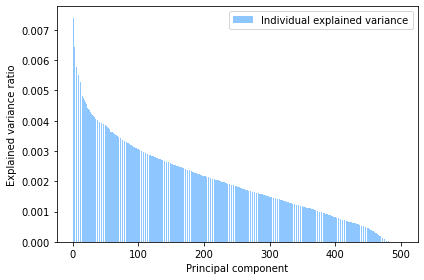

In [ ]:
# Initiate the PCA.
pca = PCA()

# Fit the PCA model to determine the transformed features.
pca.fit_transform(pca_data)

# Use the 'plot_explained_variances' function defined at the top of the
# notebook to plot the variance explained by each principal component.
plot_explained_variances(pca)

In [ ]:
# Print top words used in leading PCA components -
# Check for common theme in words that comprise the PCAs
pca1_list = pca.components_[0].tolist()
word_index = sorted(range(len(pca1_list)), key=lambda x: pca1_list[x])[-20:]
[headings[i] for i in word_index]
# words have common theme of linking to port arthur, grim but shows that 
# code is working

['scarred',
 'tasmania',
 'tourist',
 'weapon',
 '1996',
 'arsenal',
 'uncovers',
 'speaks',
 'reveals',
 'denhamhitchcock',
 'killed',
 'dark',
 'document',
 'longlost',
 'bryants',
 'massacre',
 'bryant',
 'martin',
 'port',
 'arthur']

## k-means 

### Elbow Curve

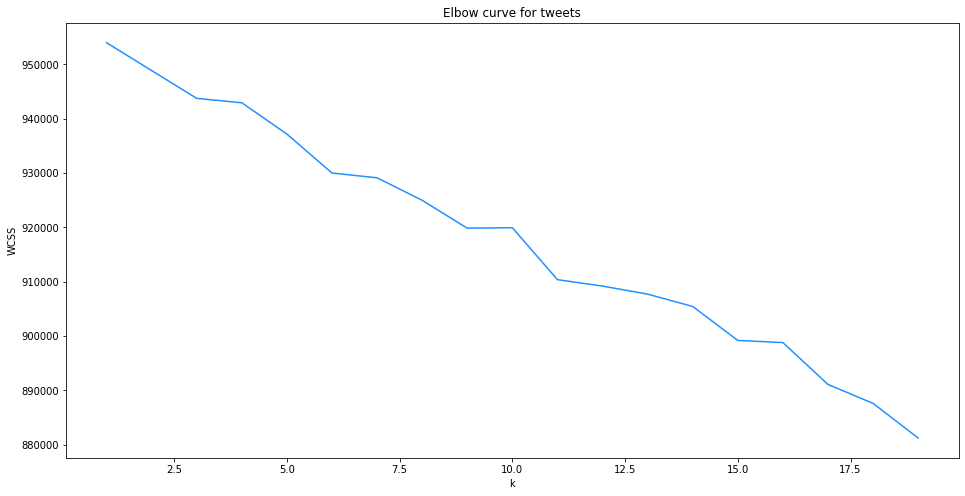

In [ ]:
# Create a separate array of tweets/words for k_means
tweets_array = tfidf_array

# Create a scaler so that the features in the dataset can be
# scaled to have a mean of 0 and a standard deviation of 1.
scaler = StandardScaler()

# Calculate the WCSS or inertia for different values of K.
WCSS = []
K = range(1,20)
for k in K:
    kmeans2 = KMeans(n_clusters=k,init='k-means++')
    pipeline2 = make_pipeline(scaler,kmeans2)
    pipeline2.fit(tweets_array)
    WCSS.append(kmeans2.inertia_)

# Plot the elbow curve. 
plt.figure(figsize=(16,8))
plt.plot(K, WCSS,color='dodgerblue')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Elbow curve for tweets')
plt.show()

### k-means fitting

In [ ]:
# Perform K-means clustering on tweets.

# Create a KMeans model with k clusters.
# Come back after plotting elbow curve
# Slight kink at 11 clusters - Curve is not great but expected for PCA on 
# vectorised text on TFIDF
k = 11
kmeans = KMeans(n_clusters=k,init='k-means++')

# Create a pipeline to link together the scaler and kmeans instance.
pipeline = make_pipeline(scaler,kmeans)

# Build a K-means clustering model by fitting the pipeline to the tweets dataset.
kmeans = pipeline.fit(tweets_array)

### Wordmap 

500
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 4 ...
Getting wordcloud for topic 5 ...
Getting wordcloud for topic 6 ...
Getting wordcloud for topic 7 ...
Getting wordcloud for topic 8 ...
Getting wordcloud for topic 9 ...
Getting wordcloud for topic 10 ...
Getting wordcloud for topic 11 ...


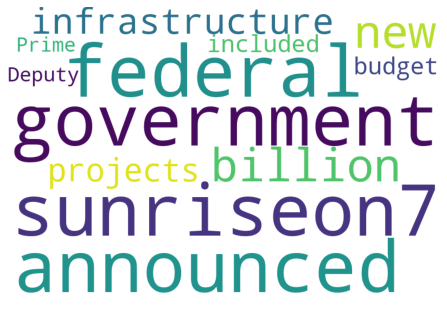

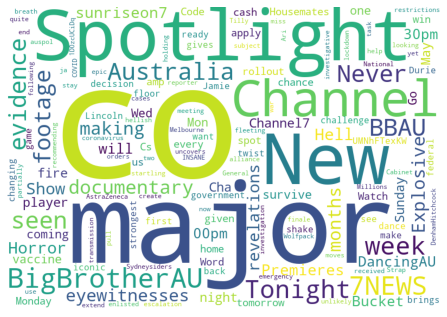

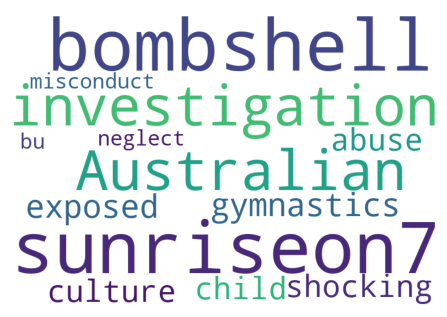

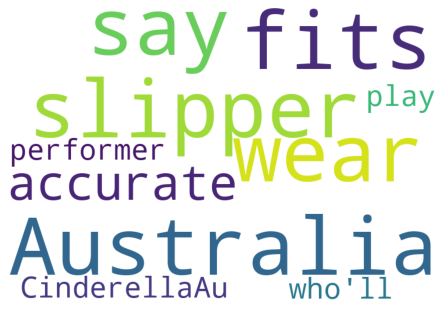

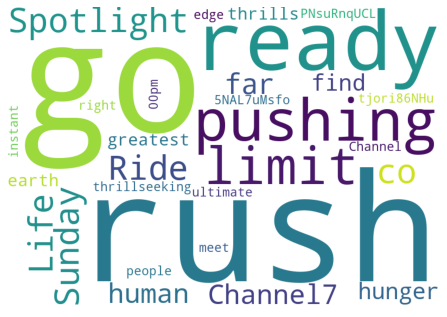

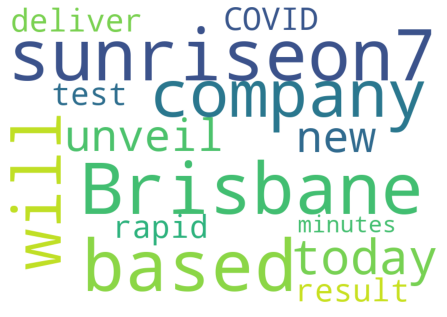

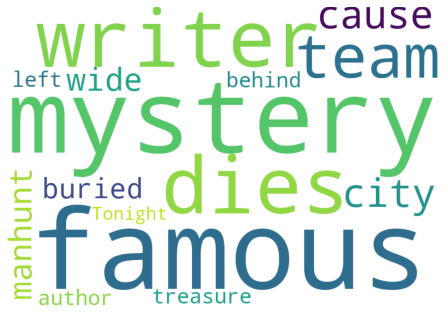

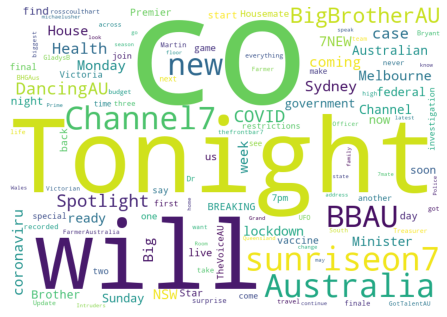

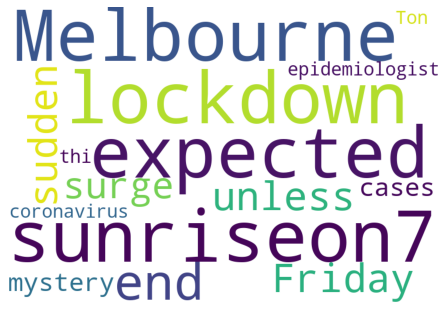

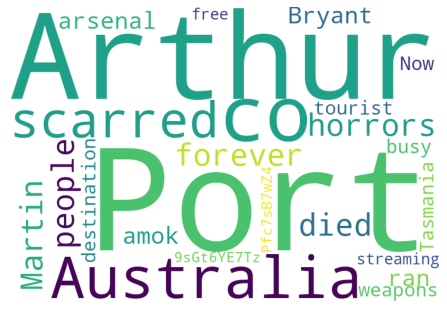

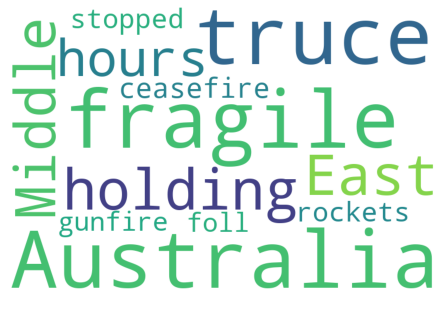

In [ ]:
# Plot a wordmap of common words used in each k-means cluster 

# Create array of labels for tweets
labels_tfidf_kmeans = kmeans.predict(tweets_array)

## Check that the length = number of tweets 
print(len(labels_tfidf_kmeans))

## Converting clustering labels into arrays and a set
labels1 = np.array(labels_tfidf_kmeans)
distinct_labels1 =  set(labels_tfidf_kmeans)

## Labelling original data into which cluster they fell into
test['label_TFIDF_KMeans'] = list(labels_tfidf_kmeans)

# Add list of words to hide from word cloud, will probably 
# look to clean these up in cleaning stage later on 
hidden_words2 = ['RT','https','7plus','7News'] 

# Create a word cloud to help identify the meaning of
# each 'topic' identified in the KMeans clustering.
for each in range(0,k):
    get_wordcloud(each,'label_TFIDF_KMeans',hidden_words2)



# Share Price Models

Data Exploration on Share prices

In [ ]:
## Investigate share price data
df_shares.shape
#df_shares.columns

(9159, 11)

In [ ]:
## Top rows
pd.options.display.float_format = '{:,.2f}'.format
df_shares.head(20)

,Code,Exchange,SrcTime,GMT,Open,High,Low,Close,Volume,Value,Transactions
0,NEC,ASX,1/07/2020T10:00:00,1/07/2020T0:00:00,138.50,139.00,137.00,138.25,262997,"362,612.86",177
1,NEC,ASX,1/07/2020T10:10:00,1/07/2020T0:10:00,138.50,139.00,137.50,137.75,255503,"353,482.35",129
2,NEC,ASX,1/07/2020T10:20:00,1/07/2020T0:20:00,137.75,138.50,137.75,138.00,60596,"83,654.97",47
3,NEC,ASX,1/07/2020T10:30:00,1/07/2020T0:30:00,138.50,139.50,138.50,139.50,138923,"193,207.13",90
4,NEC,ASX,1/07/2020T10:40:00,1/07/2020T0:40:00,139.50,140.00,139.50,139.50,93188,"130,133.13",72
5,NEC,ASX,1/07/2020T10:50:00,1/07/2020T0:50:00,139.50,140.00,139.50,140.00,101715,"142,017.70",65
6,NEC,ASX,1/07/2020T11:00:00,1/07/2020T1:00:00,140.00,141.00,140.00,141.00,80514,"113,189.87",68
7,NEC,ASX,1/07/2020T11:10:00,1/07/2020T1:10:00,141.00,141.50,140.50,140.75,70606,"99,538.73",109
8,NEC,ASX,1/07/2020T11:20:00,1/07/2020T1:20:00,141.00,141.25,140.50,140.50,19365,"27,261.18",35
9,NEC,ASX,1/07/2020T11:30:00,1/07/2020T1:30:00,140.50,140.50,139.75,140.00,157123,"219,995.16",109


## Create a suitable response variable for share price movement

In [ ]:
### Option 1
## Find share price at next available time after tweet if higher than last closing: higher, same = same, lower = lower

## Find nearest date
# Create array of datetimes for shares
time_stamp = [datetime.strptime(i,"%d/%m/%YT%H:%M:%S") for i in df_shares['SrcTime']]
share_times_array = np.array(time_stamp)  

In [ ]:

#df_sample = df.sample(n = 5, random_state= np.random.randint(58))
df_sample['nearest_time'] = [find_nearest_times(i, n =1, before_after= 'after') for i in df_sample['tweet_post_time']]
df_sample[['tweet_post_time','nearest_time']].head(5)

,tweet_post_time,nearest_time
135086,25/03/2013 2:02,1/07/2020T10:00:00
29132,18/08/2013 9:21,1/07/2020T10:00:00
96894,3/08/2019 8:28,1/07/2020T10:00:00
244,26/05/2021 5:44,26/05/2021T10:00:00
135313,3/08/2012 5:17,1/07/2020T10:00:00


In [ ]:
df_shares['SrcTime'].iloc[0]

'1/07/2020T10:00:00'

In [ ]:
### Option 2 

## Calculation: Compare (1)Value right before tweet with (2)Average closing price for next x days following tweet

## Advantages: 
  # - Allows for x days of price movement
  # - Choosing 1 point in time for value before simplifies calculation  
  # - Simple to understand

## Disadvantages:
  # - Does not allow for pre-market movement over non-trading days
  # - Does not account for volume
  # - Does not account for price volatility before

In [ ]:
### Option 3

## Calculation: Compare (1) Average over last 6 ticks with (2) Average closing for next market day

## Advantages:   
  # - Allows for trading day
  # - Allows for average last 6 ticks

## Disadvantages:
  # - Does not account for volume

In [ ]:
### Option 4

## Calculation: Compare (1) Average over last 6 ticks with (2) Average closing for next market day

## Advantages:   
  # - Allows for trading day
  # - Allows for average last 6 ticks

## Disadvantages:
  # - Does not account for volume

# Appendix
Bug fixing done down here/code that might come in handy for evaluation of models/ future work

In [ ]:
tfidf_array = pd.DataFrame(embedding_tfidf.toarray())
# 
word_vector = test['tweet_text'].apply(pd.Series).stack().reset_index(drop = True)
list_words = list(word_vector)
headings = create_dictionary(list_words)
# Create array
tfidf_array.columns = headings

In [ ]:
# print top words used in PCA components

pca1_list = pca.components_[5].tolist()
word_index = sorted(range(len(pca1_list)), key=lambda x: pca1_list[x])[-20:]
[headings[i] for i in word_index]

In [ ]:
### Define a function to find the nearest share prices

def closest_dates(dates, tweet_date, n):
    sorted_list = sorted([d for d in dates if d > pivot], key=lambda t: t - pivot)
    return sorted_list[:n]

## Currently quite slow - might do function in steps before going to production
def find_nearest_times(x, n, before_after):

    # Convert tweet time into datetime
    tweet_dt = datetime.strptime(x,"%d/%m/%Y %H:%M")
    
    # Find closest time after
    if before_after == 'after':
        sorted_list = sorted([d for d in share_times_array if d > tweet_dt], key=lambda t: t - tweet_dt)
    elif before_after == 'before':
        sorted_list = sorted([d for d in share_times_array if d <= tweet_dt], key=lambda t: t - tweet_dt)

    # Convert back into original time format. 
    closest_time = sorted_list[:n][0]
    closest_time = closest_time.strftime("%-d/%m/%YT%H:%M:%S")
    return closest_time

# Development code

In [ ]:
#df_sample = df.sample(n = 5, random_state= np.random.randint(58))

df_sample['nearest_time'] = [find_nearest_times(i, n =1) for i in df_sample['tweet_post_time']]
df_sample[['tweet_post_time','nearest_time']].head(5)
df_sample

In [ ]:
# Define a function to find the nearest share prices
# Currently quite slow - might do function in steps before going to production
def closest_dates(dates, tweet_date, n):
    sorted_list = sorted([d for d in dates if d > pivot], key=lambda t: t - pivot)
    return sorted_list[:n]
def find_nearest_times(x, n, before_after):

    # Convert tweet time into datetime
    tweet_dt = datetime.strptime(x,"%d/%m/%Y %H:%M")
    
    # Find closest time after
    if before_after == 'after':
        sorted_list = sorted([d for d in share_times_array if d > tweet_dt], key=lambda t: t - tweet_dt)
    elif before_after == 'before':
        sorted_list = sorted([d for d in share_times_array if d < tweet_dt], key=lambda t: tweet_dt - t)
        
    # Convert back into original time format. 
    closest_time = sorted_list[:n][0]
    closest_time = closest_time.strftime("%-d/%m/%YT%H:%M:%S")
    return closest_time

In [ ]:
## Create code that returns closing price.
# Add only 1 column (City)
df_sample1 = df_sample.merge(df_shares[['SrcTime','Close']], how='left', left_on='nearest_time',right_on = 'SrcTime')
df_sample1